# TD 2 - Computational Statistics - MVA 23-24
### Meilame TAYEBJEE

In [94]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.special import logsumexp
import pandas as pd

## Exercise 1: Discrete distributions

In [95]:
def generateDistrib(p, x, N = 1):
    """
    Args:
        p (list or array shape (1,n)): list of probabilities
        x (list or array shape (1,n)): list of sorted values
        N (int): number of values to generate
        
    Returns
        (list): list of N values x generated according to the distribution p
    """

    u = np.random.rand(N)
    P = np.cumsum(p)
    res = []
    for i in range(N):
        res.append(x[np.where(P-u[i] > 0)[0][0]]) # appends x[i] where i is the first index where P-u[i] > 0 ie P[i-1] < u[i] < P[i]
    return res


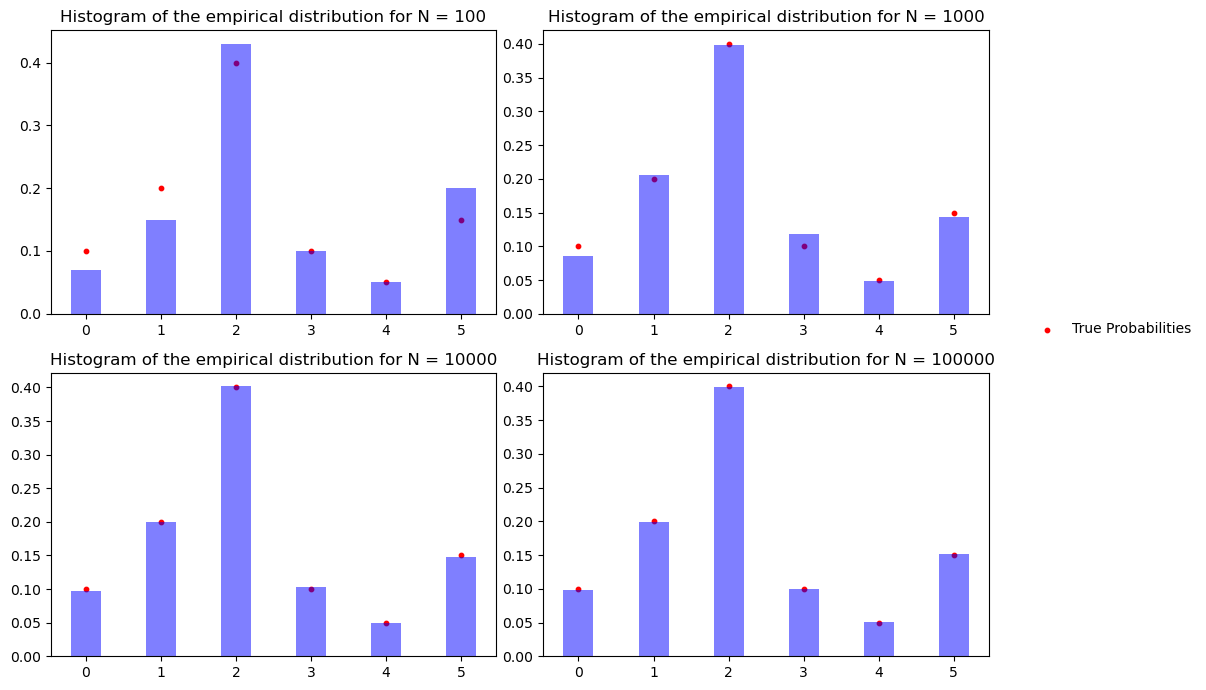

In [96]:
#---------INPUTS-------------#
p = [0.1, 0.2, 0.4, 0.1, 0.05, 0.15] # Probabilities
x = range(6) # Values
#----------------------------#

Ns = [100, 1000, 10000, 100000] #We make vary the number of simulations

fig = plt.figure(figsize=(10, 7))
for N in Ns:
    plt.subplot(2,2,Ns.index(N)+1)
    plt.hist(generateDistrib(p, x, N), density = True, bins = range(7), rwidth = 0.4, align = 'left', alpha = 0.5, color = 'b')
    plt.scatter(x, p, color = 'red', s = 10, label = "True probabilities")
    plt.title("Histogram of the empirical distribution for N = {}".format(N))

fig.legend(['True Probabilities'], bbox_to_anchor=(1.2, 0.55), frameon = False)
plt.tight_layout()
plt.show()

## Exercise 2: GMM and the EM algorithm

### GMM generation and visualization

In [97]:
def generateGMM(alphas, mus, Sigmas, N = 1):
    """
    Args:
        alphas (list or array shape (1,p)): list of probabilities, p being the number of clusters
        mus (list or array shape (p,d = 2)): list of means
        Sigmas (array shape (d,d,p)): list of covariance matrices
        N (int): number of samples to generate

    Returns
        (list): list of N values x generated according to the GMM model
        (list): list of N values z generated according to the GMM model (the cluster assignements) (which are not supposed to be observed)
    """

    p = len(alphas) #number of clusters
    clusters_assignment = generateDistrib(alphas, range(p), N) #assigns each sample to a cluster ; basically contains z1...zN. We use the exercise 1 function
    res = []
    for i in range(N):
        #generation of x_i according to the multivariate normal distribution (mu_[z_i], Sigma_[z_i])
        res.append(np.random.multivariate_normal(mus[clusters_assignment[i]], Sigmas[:,:,clusters_assignment[i]])) 

    return res, clusters_assignment

---- CLUSTER 1 ----
Mean :  [0, 0]
Covariance matrix :  [[3.20581274 0.09221522]
 [0.09221522 3.04261811]]
Expected proportion of samples (alpha_0) :  0.1

---- CLUSTER 2 ----
Mean :  [10, 10]
Covariance matrix :  [[8.60995825 0.07389292]
 [0.07389292 3.00097382]]
Expected proportion of samples (alpha_1) :  0.45

---- CLUSTER 3 ----
Mean :  [0, 10]
Covariance matrix :  [[9.53629109 4.9919706 ]
 [4.9919706  6.85987244]]
Expected proportion of samples (alpha_2) :  0.3

---- CLUSTER 4 ----
Mean :  [10, 0]
Covariance matrix :  [[14.78447184 10.48470404]
 [10.48470404 12.33498577]]
Expected proportion of samples (alpha_3) :  0.15



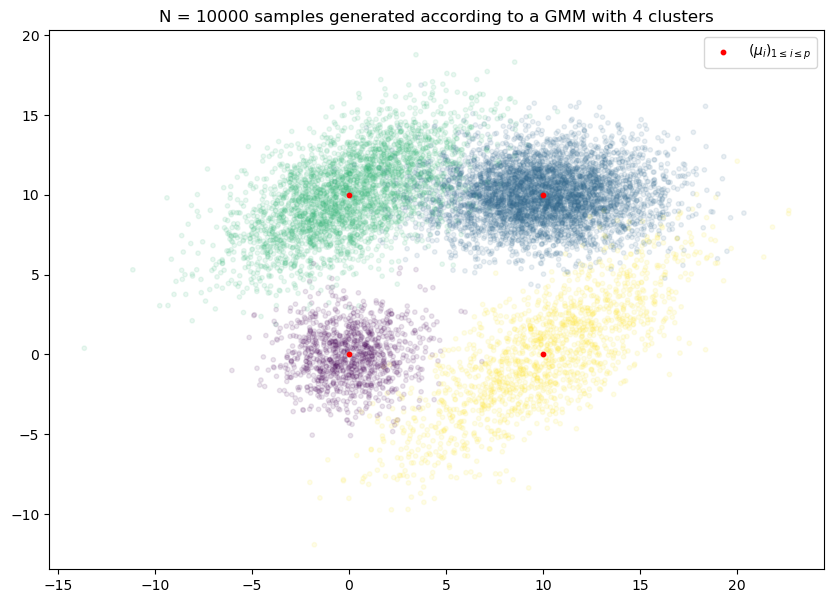

In [98]:
p = 4 #Number of clusters
alphas = [0.1, 0.45, 0.3, 0.15] #P(z) (parameters of the multinomial distribution)

if sum(alphas) != 1:
    raise ValueError("The sum of the probabilities must be equal to 1")


mus = [[0,0], [10,10], [0,10], [10,0]] #Means of the clusters
N = 10000 #Number of simulations

reg = 3 #Regularization parameter (Sigma = A.T @ A + reg*I)

Sigmas = np.zeros((2,2,p))
for i in range(p):
    A = (i+1)*np.random.rand(2,2)  #A is a random matrix
    Sigmas[:,:,i] = A.T @ A + reg*np.eye(2) #Covariance matrices of the clusters, positive definite
    print("---- CLUSTER {} ----".format(i+1))
    print("Mean : ", mus[i])
    print("Covariance matrix : ", Sigmas[:,:,i])
    print("Expected proportion of samples (alpha_{}) : ".format(i), alphas[i])
    print("")


X, Z = generateGMM(alphas, mus, Sigmas, N)

plt.figure(figsize=(10, 7))

scatter = plt.scatter([x[0] for x in X], [x[1] for x in X], s = 10, alpha = 0.1, c=Z, cmap='viridis')
plt.scatter([mus[i][0] for i in range(p)], [mus[i][1] for i in range(p)], color = 'red', s = 10, label = "$(\mu_i)_{1 \leq i \leq p}$")
plt.legend()
plt.title("N = {} samples generated according to a GMM with {} clusters".format(N, p))
plt.show()

### EM Algorithm

In [99]:
def EM_Algorithm(X, alphas_init, mus_init, Sigmas_init, Niter = 100, eps = 1e-2, reg = 1e-6, verbose = False):
    """
    Args:
        X (array shape (N,d)): list of N samples
        alphas_init (list or array shape (1,p)): initialization of the estimator of alpha
        mus_init (list or array shape (p,d)): initialization of the estimator of alpha
        Sigmas_init (array shape (d,d,p)): initialization of the estimator of Sigmas^-1
        Niter (int): number of iterations max
        eps (float): tolerance parameter

    Returns
        (list), size Niter: list of log-likelihoods over the iterations
        (list), size Niter: list of the estimator of alphas over the iterations
        (list), size Niter: list of the estimator of mus over the iterations
        (list), size Niter: list of the estimator of Sigmas over the iterations
    """

    N = len(X)
    p = len(alphas_init)
    X = np.array(X)

    #These will always contain the "last" estimator of alphas, mus and Sigmas (Theta^t)
    alphas = alphas_init 
    mus = mus_init
    Sigmas = Sigmas_init

    #These will contain the estimators of alphas, mus and Sigmas and also the responsabilities (posterior of z) over the iterations
    all_alphas = [alphas]
    all_mus = [mus]
    all_Sigmas = [Sigmas]
    all_taus = []
    
    #This will contain the log-likelihoods over the iterations
    log_likelihoods = []

    for iter in range(Niter):
        if verbose:
            print("Iteration {}".format(iter+1))
        #E-step (update of tau)

        log_numerator = np.zeros((N,p)) #responsabilities
        for i in range(N):
            for j in range(p):
                log_numerator[i,j] = np.log(alphas[j]) - 0.5* np.linalg.slogdet(Sigmas[:,:,j])[1] - 0.5*(X[i]-mus[j]) @ (np.linalg.pinv(Sigmas[:,:,j]))@ (X[i]-mus[j])
        
        log_denominator = logsumexp(log_numerator, axis=1) #shape (N,)
        if iter > 1:
            log_likelihoods.append(np.sum(log_denominator)) #The log likelihood is the sum of the log of the denominator of the posterior of z

        tau = np.exp(log_numerator - np.repeat(log_denominator[:,np.newaxis], p, axis = 1)) #shape (N,p), contains the tau_{i,j}
        all_taus.append(tau)
        #M-step
        alphas = np.sum(tau, axis = 0)/N
        for k in range(p):
            mus[k,:] = np.sum([tau[n,k]*X[n] for n in range(N)], axis = 0)/np.sum(tau[:,k])
            Sigmas[:,:,k] = np.sum([tau[n,k]*np.outer(X[n]-mus[k], X[n]-mus[k]) for n in range(N)], axis = 0)/np.sum(tau[:,k])
            Sigmas[:,:,k] += reg*np.eye(2)




        all_alphas.append(alphas)
        all_mus.append(mus)
        all_Sigmas.append(Sigmas)

        #Stopping criterion
        if iter > 2 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < eps:
            break

    return log_likelihoods, all_alphas, all_mus, all_Sigmas, all_taus

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34


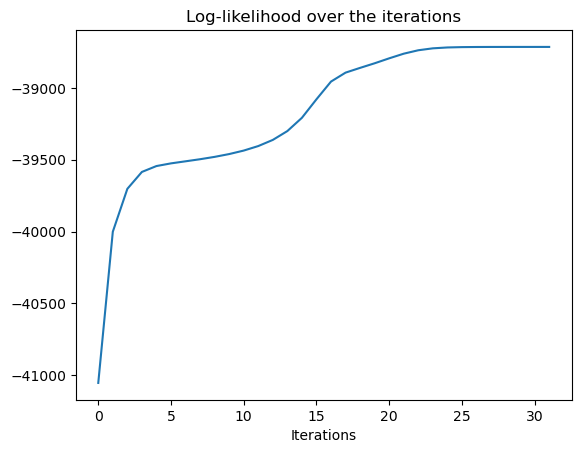

True alphas :  [0.1  0.15 0.3  0.45]
Estimated alphas :  [0.10683288 0.14928155 0.29569413 0.44819144]

True mus :  [[ 0  0]
 [10  0]
 [ 0 10]
 [10 10]]
Estimated mus :  [[ 4.13760788e-02 -5.34985791e-02]
 [ 1.00180660e+01 -6.16946941e-02]
 [-6.57731278e-03  9.99071834e+00]
 [ 9.94399909e+00  9.99235127e+00]]


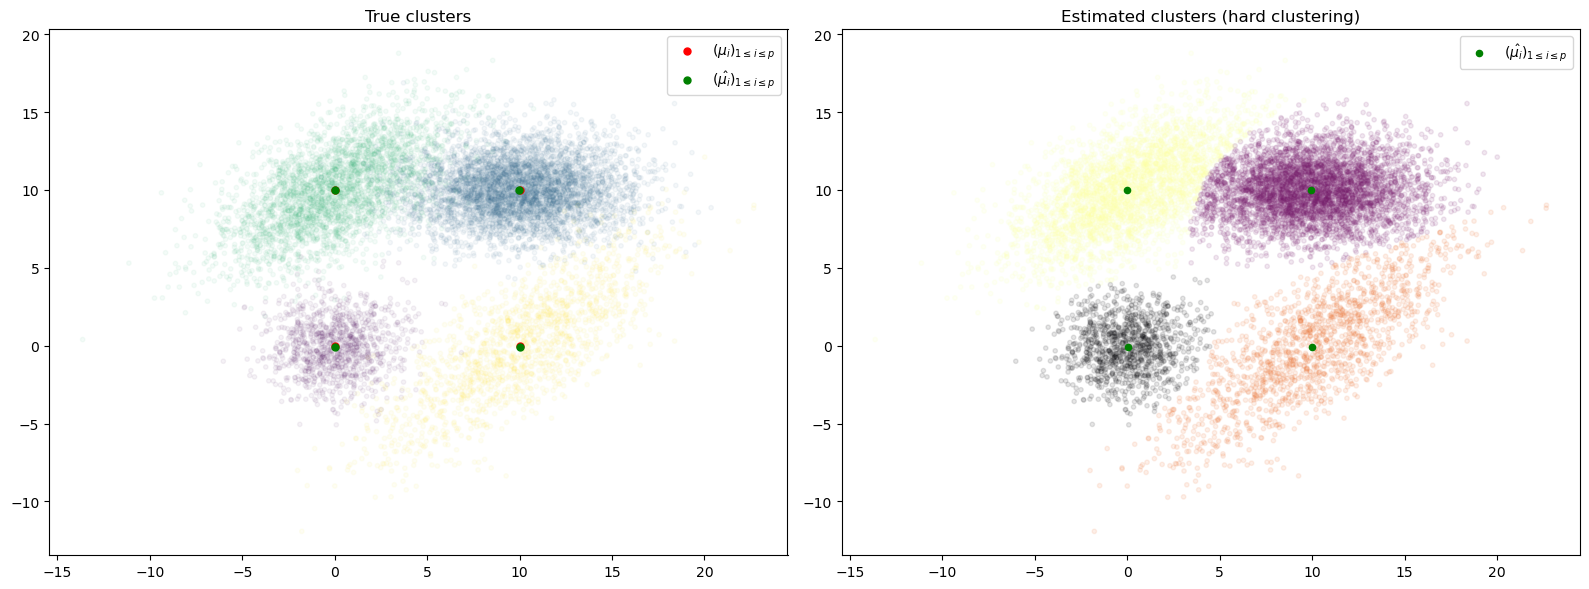

In [100]:
#------INIT------#

mus_init = np.random.randn(p,2) #Initialization of the estimator of mus

#Initialization of the estimator of Sigmas
Sigmas_init = np.zeros((2,2,p))
for j in range(p):
    A = np.random.rand(2,2)
    Sigmas_init[: ,: , j] = A.T @ A +np.eye(2) 


alphas_init = np.random.rand(p) 
alphas_init /=  np.sum(alphas_init) #Initialization of the estimator of alphas

#------EM ALGORITHM------#
log_likelihoods, all_alphas, all_mus, all_Sigmas, all_taus = EM_Algorithm(X, alphas_init, mus_init, Sigmas_init, reg = 0, verbose=True)
plt.plot(range(len(log_likelihoods)), log_likelihoods)
plt.title("Log-likelihood over the iterations")
plt.xlabel("Iterations")
plt.show()

predicted_alphas = all_alphas[-1]
predicted_mus = all_mus[-1]
predicted_Sigmas = all_Sigmas[-1]
predicted_taus = all_taus[-1]

hard_clustering = np.argmax(predicted_taus, axis = 1) #hard clustering: tau_{i,j} = P(z = j | x_i) so we take the argmax over j (the most likely cluster) for each sample i

pred_alpha_to_mu = {predicted_alphas[i]:predicted_mus[i] for i in range(p)} #dictionary that associates each alpha to its corresponding mu
alphas_to_mu = {alphas[i]:mus[i] for i in range(p)} #dictionary that associates each alpha to its corresponding mu

alphas = np.sort(alphas)
predicted_alphas = np.sort(predicted_alphas)
mus = np.array([alphas_to_mu[alpha] for alpha in alphas])
predicted_mus = np.array([pred_alpha_to_mu[alpha] for alpha in predicted_alphas])

#------ ALPHAS------#
print("True alphas : ", alphas)
print("Estimated alphas : ", predicted_alphas)
print("")

#------ MUS------#
print("True mus : ", mus)
print("Estimated mus : ", predicted_mus)


#------Plot estimated clusters------#
fig = plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.scatter([x[0] for x in X], [x[1] for x in X], s = 10, alpha = 0.05, c=Z, cmap='viridis')
plt.scatter([mus[i][0] for i in range(p)], [mus[i][1] for i in range(p)], color = 'red', s = 25, label = "$(\mu_i)_{1 \leq i \leq p}$")
plt.scatter([predicted_mus[i][0] for i in range(p)], [predicted_mus[i][1] for i in range(p)], color = 'green', s = 25, label = "$(\hat{\mu_i})_{1 \leq i \leq p}$")
plt.title("True clusters")
plt.legend()
plt.subplot(1,2,2)
scatter = plt.scatter([x[0] for x in X], [x[1] for x in X], s = 10, alpha = 0.1, c=hard_clustering, cmap='inferno')
plt.scatter([predicted_mus[i][0] for i in range(p)], [predicted_mus[i][1] for i in range(p)], color = 'green', s = 20, label = "$(\hat{\mu_i})_{1 \leq i \leq p}$")
plt.title("Estimated clusters (hard clustering)")
plt.legend()
plt.tight_layout()
plt.show()



### Application: Crude Birth/Death Rate

In [101]:
df = pd.read_csv("dataTP2.csv", sep = ",")
df

,LocID,Location,VarID,Variant,Time,MidPeriod,TFR,NRR,CBR,Births,...,CDR,Deaths,DeathsMale,DeathsFemale,CNMR,NetMigrations,GrowthRate,NatIncr,SRB,MAC
0,4,Afghanistan,2,Medium,1950-1955,1953,7.450,1.636,50.314,2015.476,...,36.862,1476.605,794.020,682.585,-0.499,-20.0,1.296,13.452,1.060,29.835
1,4,Afghanistan,2,Medium,1955-1960,1958,7.450,1.765,50.998,2201.589,...,33.718,1455.605,783.110,672.495,-0.463,-20.0,1.683,17.280,1.060,29.835
2,4,Afghanistan,2,Medium,1960-1965,1963,7.450,1.899,51.477,2439.130,...,30.808,1459.784,777.437,682.347,-0.422,-20.0,2.026,20.669,1.060,29.835
3,4,Afghanistan,2,Medium,1965-1970,1968,7.450,2.017,51.646,2728.221,...,28.223,1490.896,790.745,700.151,-0.379,-20.0,2.307,23.423,1.060,29.835
4,4,Afghanistan,2,Medium,1970-1975,1973,7.450,2.141,51.234,3056.451,...,25.495,1520.938,802.414,718.524,-0.335,-20.0,2.544,25.739,1.060,29.835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14935,716,Zimbabwe,2,Medium,2075-2080,2078,1.913,0.919,14.153,2100.753,...,9.407,1396.229,729.240,666.989,-0.337,-50.0,0.441,4.746,1.021,29.872
14936,716,Zimbabwe,2,Medium,2080-2085,2083,1.877,0.903,13.429,2030.941,...,10.001,1512.603,794.805,717.798,-0.331,-50.0,0.310,3.428,1.021,29.984
14937,716,Zimbabwe,2,Medium,2085-2090,2088,1.849,0.891,12.867,1970.518,...,10.631,1627.991,853.756,774.235,-0.326,-50.0,0.191,2.236,1.021,30.094
14938,716,Zimbabwe,2,Medium,2090-2095,2093,1.831,0.883,12.492,1926.925,...,11.191,1726.185,899.147,827.038,-0.324,-50.0,0.098,1.301,1.021,30.201


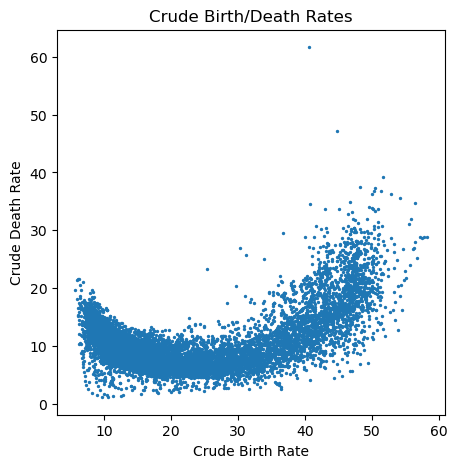

In [102]:
df = pd.read_csv("dataTP2.csv", sep = ",")
df = df[["CBR", "CDR"]]

#------Plot data------#
plt.figure(figsize=(5, 5))
plt.scatter(df["CBR"], df["CDR"], s = 2)
plt.title("Crude Birth/Death Rates")
plt.xlabel("Crude Birth Rate")
plt.ylabel("Crude Death Rate")
plt.show()



In [103]:
X = np.array(df)
#Drop nans
X = X[~np.isnan(X).any(axis=1)]
#X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
print("We have {} sample".format(X.shape[0]))

We have 13290 sample


In [104]:
p = 10 #number of clusters

#------INIT------#

mus_init = np.max(X, axis = 0)*np.random.rand(p,2) #Initialization of the estimator of mus

#Initialization of the estimator of Sigmas
Sigmas_init = np.zeros((2,2,p))
for j in range(p):
    A = np.random.rand(2,2)
    Sigmas_init[: ,: , j] = A.T @ A +np.eye(2) 


alphas_init = np.random.rand(p) 
alphas_init /=  np.sum(alphas_init) #Initialization of the estimator of alphas
#------EM ALGORITHM------#

log_likelihoods, all_alphas, all_mus, all_Sigmas, all_taus = EM_Algorithm(X, alphas_init, mus_init, Sigmas_init, Niter = 20, verbose = True)
plt.plot(range(len(log_likelihoods)), log_likelihoods)
plt.title("Log-likelihood over the iterations")
plt.xlabel("Iterations")
plt.show()

predicted_alphas = all_alphas[-1]
predicted_mus = all_mus[-1]
predicted_Sigmas = all_Sigmas[-1]
predicted_taus = all_taus[-1]

hard_clustering = np.argmax(predicted_taus, axis = 1) #hard clustering: tau_{i,j} = P(z = j | x_i) so we take the argmax over j (the most likely cluster) for each sample i

#------ ALPHAS------#
print("Estimated alphas : ", np.sort(predicted_alphas))
print("")
#------Plot estimated clusters------#
fig = plt.figure(figsize=(16, 6))
plt.scatter(df["Births"], df["Deaths"], s = 2)
plt.scatter([predicted_mus[i][0] for i in range(p)], [predicted_mus[i][1] for i in range(p)], color = 'green', s = 25, label = "$(\hat{\mu_i})_{1 \leq i \leq p}$")
plt.title("Estimated clusters")
plt.legend()

print("Estimated clusters : ")
for i in range(p):
    print("Cluster {} : ".format(i+1), predicted_mus[i])

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8


KeyboardInterrupt: 

In [ ]:
def computeBIC(log_likelihood, p, N):
    """
    Args:
        likelihood (float): log-likelihood of the model
        p (int): number of estimated clusters

    Returns
        (float): BIC score of the model
    """
    freedom = p-1 + p*2 + p*2*3/2 #degree of freedom for p clusters, dimension = 2
    return -log_likelihood + 0.5*p*np.log(N)

In [ ]:
computeBIC(log_likelihoods[-1], p, X.shape[0])

-16922.55156667519

## Exercice 3: Importance Sampling

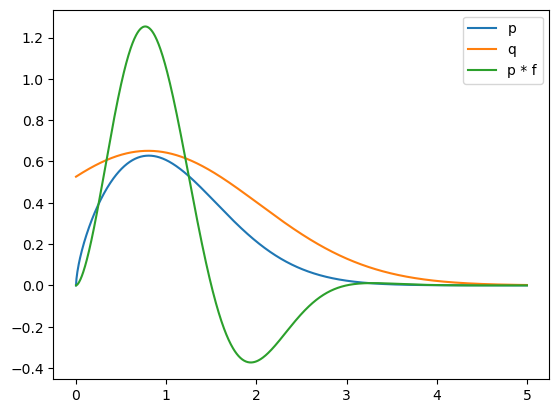

In [ ]:
def p(x):
    return (x**0.65) * np.exp(-(x**2)/2)


def f(x):
    return 2*np.sin(2*np.pi*x/3)

def q(x, mu , sigma):
    return 2*stats.norm.pdf(x, loc = mu, scale = sigma)

X= np.linspace(0,5,1000)
plt.plot(X, p(X), label = "p")
plt.plot(X, q(X, 0.8, 1.5**0.5), label = "q")
plt.plot(X, p(X)*f(X), label = "p * f")

plt.legend()
plt.show()


In [ ]:
def simpleImportanceSampling(mu, sigma, N = 1000):
    """
    Args:
        p (function): density function of the distribution we want to sample from
        f (function): function we want to integrate
        mu (float): mean of the normal distribution
        sigma (float): standard deviation of the normal distribution
        N (int): number of samples to generate

    Returns
        (float): estimator of the integral of f
    """
    X = np.random.normal(loc = mu, scale = sigma, size = N)
    X = X[X>0]
    omegas = p(X)/q(X, mu, sigma)
    omegas = omegas/np.sum(omegas)
    print((f(X)*omegas).shape)
    return f(X)*omegas
    

In [ ]:
Ns = [10, 100, 1000, 10000]

for N in Ns:
    print("N = {}".format(N))
    est= simpleImportanceSampling(mu = 0.8, sigma = np.sqrt(1.5), N = N)
    print("Mean : ", np.sum(est))
    print("Variance : ", np.var(est))
    print("")


N = 10
(5,)
Mean :  0.7124752231498184
Variance :  0.10466918809148959

N = 100
(83,)
Mean :  0.8624419194659472
Variance :  0.0003128984267183061

N = 1000
(743,)
Mean :  0.7155869388755147
Variance :  3.8295317275908655e-06

N = 10000
(7356,)
Mean :  0.7744054563252891
Variance :  3.7345064750280075e-08



In [ ]:
Ns = [10, 100, 1000, 10000]
for N in Ns:
    print("N = {}".format(N))
    est= simpleImportanceSampling(mu = 6, sigma = np.sqrt(1.5), N = N)
    print("Mean : ", np.sum(est)/N)
    print("Variance : ", np.var(est))
    print("")

N = 10
(10,)
Mean :  0.04552431890201063
Variance :  0.009909477350960871

N = 100
(100,)
Mean :  0.015496461839664822
Variance :  0.006806155174434702

N = 1000
(1000,)
Mean :  -0.00178568677686506
Variance :  0.0006007187620386653

N = 10000
(10000,)
Mean :  -0.0001263124140120179
Variance :  9.531876091900324e-06

